In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def f_true(x):
    return 0.03 * x ** 4 - 0.4 * x ** 2 + 0.7 * np.sin(2.2 * x)

def make_poly_features(x, degree):
    x = np.asarray(x).reshape(-1, 1)
    X = np.hstack([x ** i for i in range(degree + 1)])
    return X

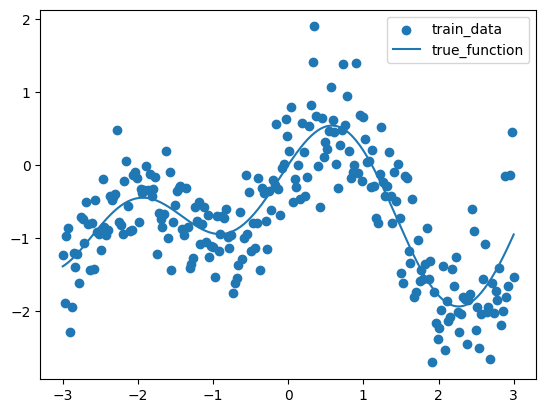

In [3]:
rng = np.random.default_rng(42)

N = 250
x = np.linspace(-3, 3, N)

sigma = 0.5
y = f_true(x) + rng.normal(0, sigma, size=x.shape)

degree = 15
X = make_poly_features(x, degree)

plt.scatter(x, y, label='train_data')
plt.plot(x, f_true(x), label='true_function')
plt.legend()
plt.show()

In [11]:
lambb = 1.0
alpha = 1.0 / (sigma ** 2)

M = X.shape[1]
posterior_cov_inv = lambb * np.eye(M) + alpha * (X.T @ X)

In [5]:
posterior_cov = np.linalg.inv(posterior_cov_inv)
mean = alpha * posterior_cov @ (X.T @ y)

In [6]:
x_new = np.linspace(-3, 3, 400)
X_new = make_poly_features(x_new, degree)

mean_pred = X_new @ mean
var_pred = 1.0 / alpha + np.sum(X_new @ posterior_cov @ X_new.T, axis=1)
std_pred = np.sqrt(var_pred)

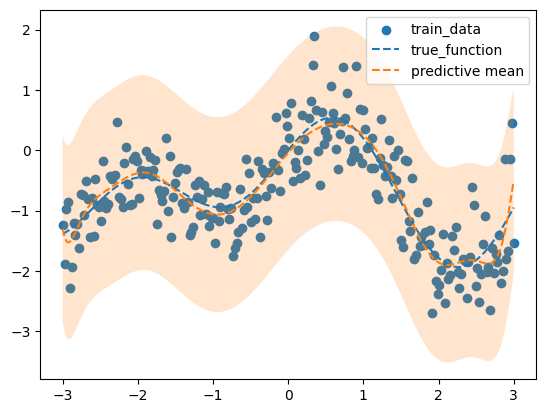

In [7]:
plt.scatter(x, y, label='train_data')
plt.plot(x_new, f_true(x_new), linestyle='--', label='true_function')
plt.plot(x_new, mean_pred, linestyle='--', label='predictive mean')

plt.fill_between(x_new, mean_pred - 2 * std_pred, mean_pred + 2 * std_pred, alpha=0.2)

plt.legend()
plt.show()

In [8]:
def log_evidence(X, y, alpha, lambdas):
    n, m = X.shape
    results = []

    XtX = X.T @ X
    yTy = float(y.T @ y)
    Xt_y = X.T @ y

    for lamb in lambdas:
        A = lamb * np.eye(m) + alpha * XtX

        sign, logdet_A = np.linalg.slogdet(A)
        if sign <= 0:
            results.append(-np.inf)
            continue

        z = np.linalg.solve(A, Xt_y)

        logdet_C = (n - m) * np.log(1 / alpha) - m * np.log(lamb) + logdet_A
        quad_term = alpha * (yTy - alpha * float(Xt_y.T @ z))

        log_ev = -0.5 * (n * np.log(2 * np.pi) + logdet_C + quad_term)
        results.append(float(log_ev))

    return np.array(results)


Best λ: 13.55425, log-evidence = -273.9101


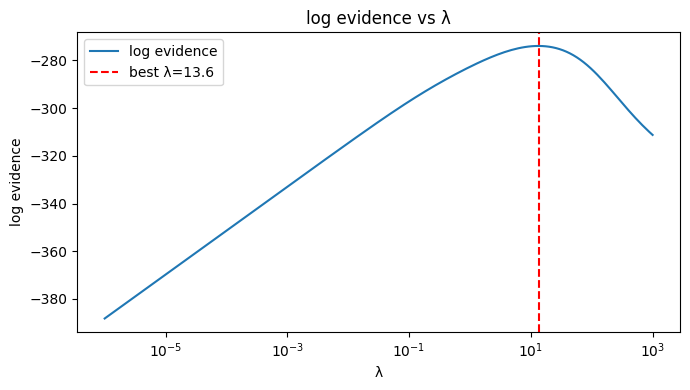

In [14]:
lambdas = np.logspace(-6, 3, 160)

log_evs = log_evidence(X, y, alpha, lambdas)

best_idx = np.nanargmax(log_evs)
best_lamb = lambdas[best_idx]
best_logev = log_evs[best_idx]

print(f"Best λ: {best_lamb:.7g}, log-evidence = {best_logev:.4f}")

plt.figure(figsize=(7,4))
plt.semilogx(lambdas, log_evs, label='log evidence')
plt.axvline(best_lamb, color='r', linestyle='--', label=f'best λ={best_lamb:.3g}')
plt.xlabel('λ')
plt.ylabel('log evidence')
plt.title('log evidence vs λ')
plt.legend()
plt.tight_layout()
plt.show()


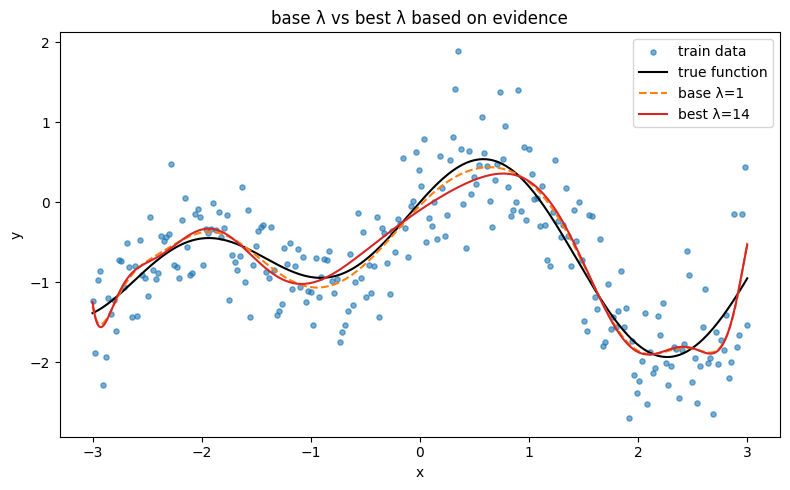

In [13]:
A = lambb * np.eye(X.shape[1]) + alpha * (X.T @ X)
w = alpha * np.linalg.solve(A, X.T @ y)
y_pred = X_new @ w

A_opt = best_lamb * np.eye(X.shape[1]) + alpha * (X.T @ X)
w_opt = alpha * np.linalg.solve(A_opt, X.T @ y)
y_pred_opt = X_new @ w_opt

plt.figure(figsize=(8, 5))
plt.scatter(x, y, s=14, color='C0', alpha=0.6, label='train data')
plt.plot(x_new, f_true(x_new), color='k', linewidth=1.5, label='true function')
plt.plot(x_new, y_pred, '--', color='C1', label=f'base λ={lambb:.2g}')
plt.plot(x_new, y_pred_opt, '-', color='C3', label=f'best λ={best_lamb:.2g}')
plt.legend()
plt.title('base λ vs best λ based on evidence')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.show()
